# Health score forecasting for asset performance management

In Asset Performance Management space it is often very important to forecasting asset health score, so reliability engineer can plan accordingly. Health score is normally calculated based on asset usage, age, maintenance, meter readings and other factors that affect asset degradation. But it's another story for future health score since future usage, meter reading etc are unknown. This article introduces a time series forecast method using Machine Learning. 

The code is tested in IBM Cloud Pak for Data.

## Load and explore the data

In [1]:
# Let's load a sample health score csv file and covert it to a dataframe
import pandas as pd
monthly_health = pd.read_csv('/project_data/data_asset/montly_health_score.csv', index_col=0)
monthly_health.index = pd.to_datetime(monthly_health.index)

In [2]:
# this dataset has 199 records
monthly_health.describe()

,health
count,199.000000
mean,80.768275
std,5.787894
min,73.149164
25%,76.126790
50%,79.405608
75%,84.006568
max,100.000000


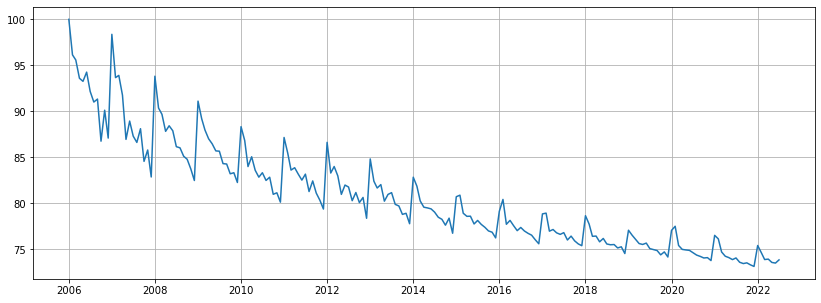

In [3]:
# plot the health score
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 5]
plt.grid(visible=True)
plt.plot(monthly_health)

This graph shows strong down trend and seasonality. The down trend is due to asset degradation. But we also notice the health score spike up at beginning of each year. This is likely due to annually maintenance. 

This time series is clearly not stationary (In order for time series data to be stationary, the data must exhibit four properties over time: 1. constant mean 2. constant variance 3. constant autocorrelation structure 4. no periodic component). 

Let's try to decompose this series.

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(x=monthly_health.health, model='additive', period=12)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

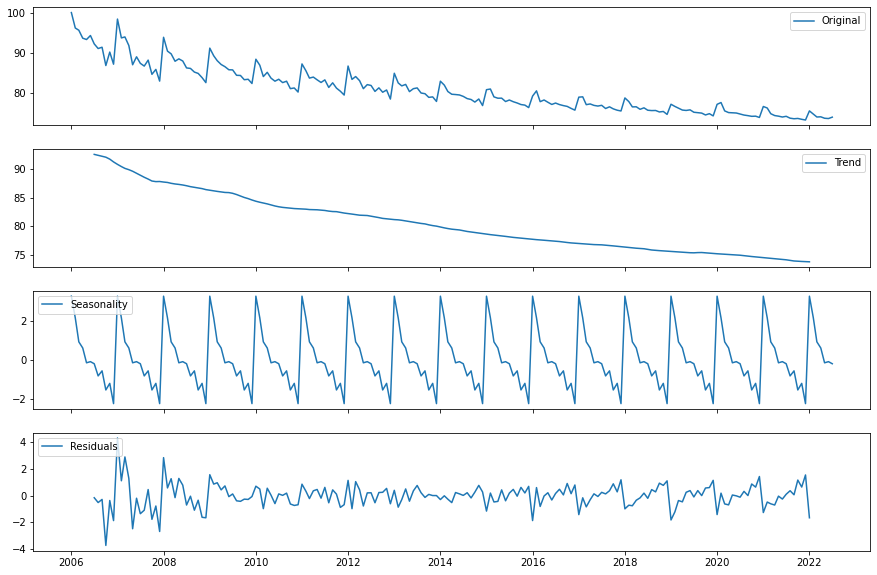

In [5]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(monthly_health.health, label='Original')
axes[0].legend(loc='upper right');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper right');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

The 2nd graph shows constant down trend (which requires one order differencing. We will explain in the subsequent section). After remove the trend component and seasonality component, the residual component appears stationary. We can apply Augmented Dickey-Fuller test (ADF).

We'll have to remove the first and last 6 values to run an ADF test since those values are all nan. ADF is very powerful tool to determine stationary property of a time series. 

In [6]:
import statsmodels.tsa.stattools as ts
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = ts.adfuller(estimated_residual[6:-6])
print("ADF statistics: ", adf_after)
print("p-value: ", pvalue_after)
print("critical_values: ", critical_values_)


ADF statistics:  -6.218003544507089
p-value:  5.3074277155681746e-08
critical_values:  {'1%': -3.4682803641749267, '5%': -2.8782017240816327, '10%': -2.5756525795918366}


We can see the p-value is less than 0.05, and the ADF statistics is significantly smaller than the critical_values. So the estimated_residual series is stationary now. 

## Build time series model 

Time series model selection is driven by the Trend and Seasonal components of our raw data. **ARIMA(p,d,q), SARIMA(p,d,q)(P,D,Q,S)** model appear good fit here. 

An ARIMA model is combination of differencing(I), AR model and MA model. SARIMA is the seasonal version of it.  
  * **MA models**: Specify that the current value of the series depends linearly on the series' mean and a set of prior (observed) white noise error terms.
  * **AR models**: Specify that the current value of the  series depends linearly on its own previous values and on a stochastic term (an imperfectly predictable term).


The ARIMA equation is: $y_t=c+\beta_0 + \beta_1y_{t-1}+\beta_2y_{t-2}+⋯+\beta_py_{t-p} +e_t+θ_1e_{t−1}+θ_2e_{t−2}+⋯+θ_qe_{t−q}$ where $e_t$ is white noise. The value $c$ is a constant value and the $\beta$, $\theta$'s are coefficients.


The key for the ARIMA/SARIMA model is to find the optimal values (p,d,q) and (P,D,Q,S). The first step is to find the d (differencing).   

Rule of differencing: A model with no orders of differencing assumes that the original series is stationary (mean-reverting). A model with one order of differencing assumes that the original series has a constant average trend. A model with two orders of total differencing assumes that the original series has a time-varying trend. See [Duke ARIMA Guide](https://people.duke.edu/~rnau/411arim2.htm)

We already discovered constant trend in first section, so one order of differencing with lag12 (due to yearly seasonality) should be good for this series.

In [7]:
# Shift 12 months
monthly_health['lag_12'] = monthly_health.shift(12)
monthly_health['seasonal_diff'] = monthly_health.health - monthly_health['lag_12']
monthly_health.head(20)

,health,lag_12,seasonal_diff
month,,,
2006-01-01,100.000000,NaN,NaN
2006-02-01,96.140734,NaN,NaN
2006-03-01,95.584674,NaN,NaN
2006-04-01,93.597984,NaN,NaN
2006-05-01,93.265001,NaN,NaN
2006-06-01,94.264848,NaN,NaN
2006-07-01,92.169534,NaN,NaN
2006-08-01,91.015646,NaN,NaN
2006-09-01,91.335386,NaN,NaN


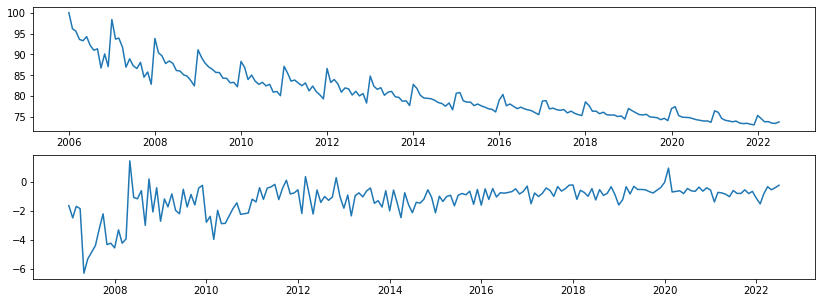

In [8]:
fig,axes = plt.subplots(2,1)
axes[0].plot(monthly_health.health,label ='original')
axes[1].plot(monthly_health.seasonal_diff,label = 'seasonal diff')

In [9]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = ts.adfuller(monthly_health.seasonal_diff[12:])
print("ADF statistics: ", adf_after)
print("p-value: ", pvalue_after)
print("critical_values: ", critical_values_)

ADF statistics:  -4.158333338954812
p-value:  0.000774475714840261
critical_values:  {'1%': -3.4687256239864017, '5%': -2.8783961376954363, '10%': -2.57575634100705}


We can see the p-value is less than 0.05, and the ADF statistics is significantly smaller than the critical_values. So the series after one order differencing (seasonal_diff) is stationary. 

Next we will determine p,q and P,Q pairs using ACF (auto correlation function) and PACP (partial auto correlation function)

This is the original series

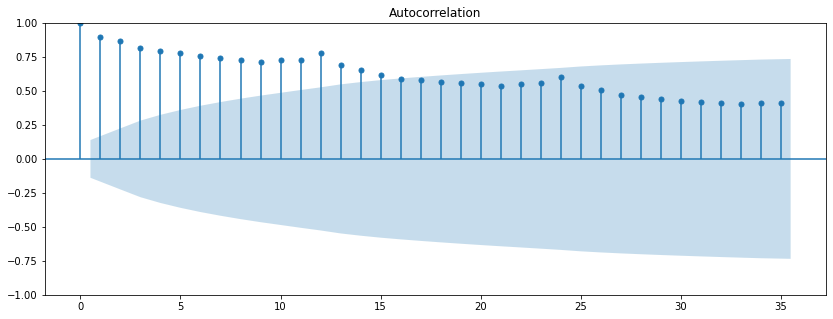

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
pp = plot_acf(monthly_health.health, lags=range(0,36))
#plot_acf(monthly_health.health, lags=range(1,25), alpha=0.05)

/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


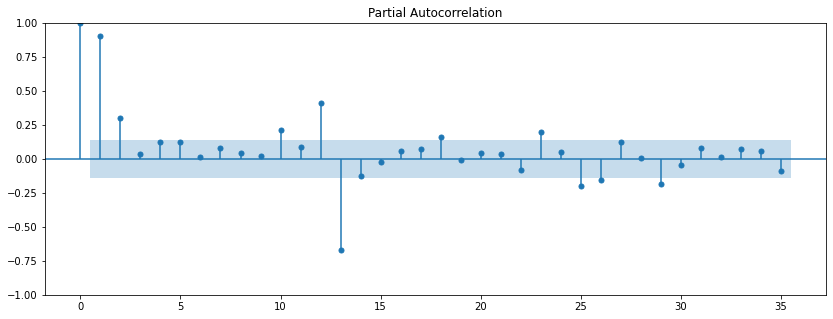

In [11]:
from statsmodels.graphics.tsaplots import plot_pacf
qq = plot_pacf(monthly_health.health, lags=range(0,36))
#plot_pacf(monthly_health.health, lags=range(1,25), alpha=0.05)

This is the one order differencing series (seasonal_diff)

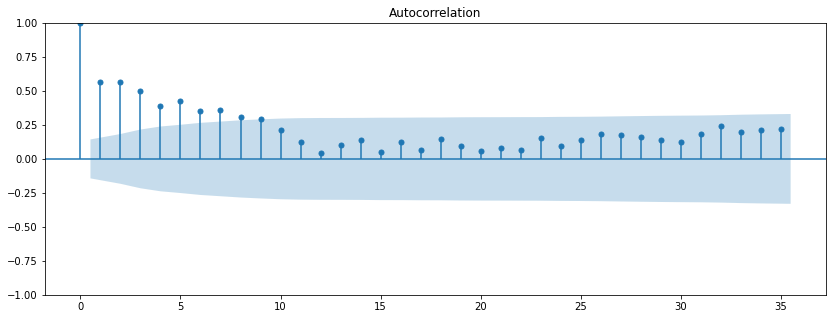

In [12]:
q = plot_acf(monthly_health.seasonal_diff[12:], lags=range(0,36))
#q = plot_acf(monthly_health.seasonal_diff[12:], lags=range(1,25), alpha=0.05)

/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


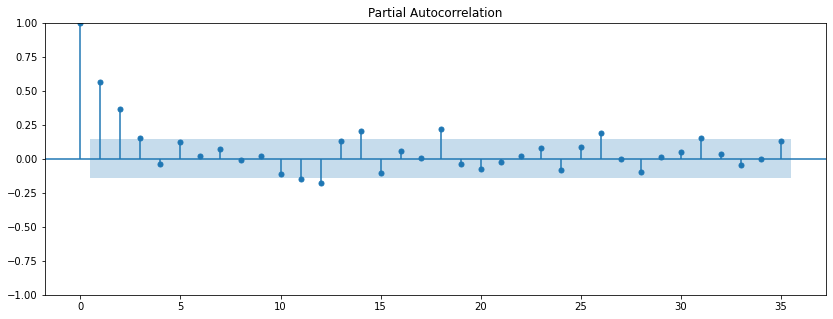

In [13]:
p = plot_pacf(monthly_health.seasonal_diff[12:], lags=range(0,36))
#p = plot_pacf(monthly_health.seasonal_diff[12:], lags=range(1,25), alpha=0.05)

### [Box-Jenkins Method](https://en.wikipedia.org/wiki/Box–Jenkins_method)

ACF Shape|Indicated Model
---|---
Exponential, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model.
Alternating positive and negative, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to help identify the order.
One or more spikes, rest are essentially zero|Moving average model, order identified by where plot becomes zero.
Decay, starting after a few lags|Mixed autoregressive and moving average (ARMA) model.
All zero or close to zero|Data are essentially random.
High values at fixed intervals|Include seasonal autoregressive term.
No decay to zero|Series is not stationary.

We see the ACF graph for seasonal_diff is exponential decaying. We can use the PACP graph to determine p. In the PACF graph, we see the first and second lag is significant. Third one is significant but not that far. So we can select the order of the p as 2 (AR). To determine q, we look at the ACF. First 8 are out of significance region. But only first 3 stand out. We will try q=3 (MA). 

We determine P, Q the similar way, instead of look for every values in the ACF and PACF graph, we look for every 12 values in the original graphs (without differencing) due to the seasonality of 12 months. We found P=1 and Q=1.

Note: One can always experiment small permutation of (p,d,q) and (P,D,Q) in the neighborhood to determine best combination. 

Now we will build the SARIMA model. we will do 150:49 split of the total 199 records, first 150 records for building the model, the last 49 for testing. 

In [14]:
import statsmodels.api as sm
sar = sm.tsa.statespace.SARIMAX(monthly_health.health[:150], 
                                order=(2,1,3), 
                                seasonal_order=(1,0,1,12) 
                                ).fit()
sar.summary()

/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74132D+00    |proj g|=  3.75543D-01

At iterate    5    f=  1.40226D+00    |proj g|=  7.80174D-02

At iterate   10    f=  1.36350D+00    |proj g|=  1.14998D-02

At iterate   15    f=  1.36221D+00    |proj g|=  2.65455D-03

At iterate   20    f=  1.36216D+00    |proj g|=  1.67781D-03

At iterate   25    f=  1.36209D+00    |proj g|=  2.71600D-03

At iterate   30    f=  1.36209D+00    |proj g|=  1.31560D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                               health   No. Observations:                  150
Model:             SARIMAX(2, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -204.313
Date:                              Fri, 30 Dec 2022   AIC                            424.626
Time:                                      20:23:54   BIC                            448.658
Sample:                                  01-01-2006   HQIC                           434.390
                                       - 06-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0134      0.277      0.048      0.961      -0.529       0.556
ar.L2         -0.2661      0.307     -0.866      0.387      -0.869       0.336
ma.L1         -0.7655      0.266     -2.875      0.004      -1.287      -0.244
ma.L2          0.4900      0.294      1.667      0.096      -0.086       1.066
ma.L3         -0.4035      0.182     -2.215      0.027      -0.761      -0.046
ar.S.L12       0.9693      0.011     89.076      0.000       0.948       0.991
ma.S.L12      -0.3637      0.082     -4.423      0.000      -0.525      -0.203
sigma2         0.7650      0.065     11.686      0.000       0.637       0.893
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):               147.03
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               0.12   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

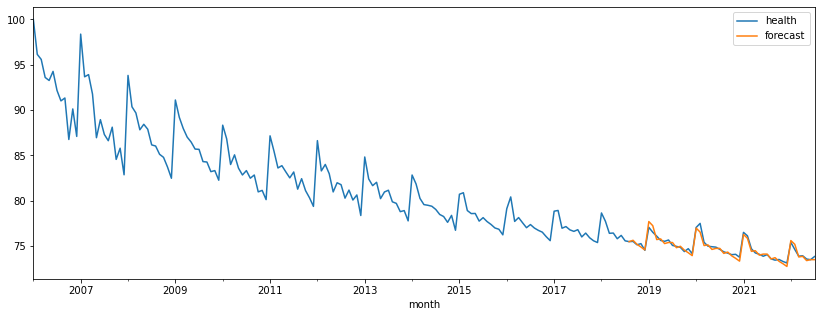

In [15]:
# plot predictions
pd.plotting.register_matplotlib_converters()
monthly_health['forecast'] = sar.predict(start = 151, end= 199)  
monthly_health[['health', 'forecast']].plot();

The testing result appears very good as the orange curve (predictions) follows along the blue curve (real values).

## Auto ARIMA
The Python pmdarima package has an autoARIMA function that grid searches/optimizes our model hyperparameters for us. 

In [16]:
!pip install pmdarima 

In [17]:
import pmdarima as pm
auto_model = pm.auto_arima(monthly_health.health[:150], start_p=0, start_q=0,
                           max_p=3, max_q=3, m=12,
                           start_P=0, start_Q=0, seasonal=True,
                           trace=True,
                           max_order=10, maxiter=100,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(auto_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=688.401, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=687.057, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=580.741, Time=0.08 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=488.246, Time=0.13 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=487.808, Time=0.39 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=488.013, Time=0.48 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=486.388, Time=0.38 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=552.046, Time=0.23 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=437.638, Time=0.52 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=521.516, Time=0.28 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=435.87

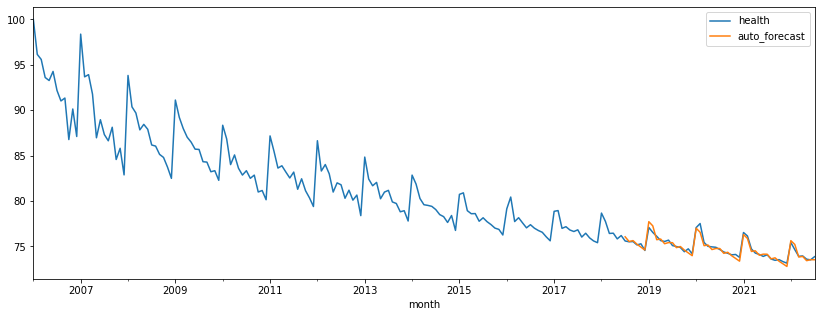

In [18]:
# plot predictions
#pd.plotting.register_matplotlib_converters()
#use model.predict() start and end in relation to series
monthly_health['auto_forecast'] = auto_model.predict(n_periods=49, start = 151)  
monthly_health[['health', 'auto_forecast']].plot();

The prediction result is very similar to the model that we build manually in last section.

## Conclusion

The above article shows a time series model to forecast asset health scores. *IBM Maximo Application Suite - Health & Predict* has more advanced models built by IBM research team for different use cases. Please check out at https://www.ibm.com/products/maximo